In [1]:
import matplotlib.pyplot as plt
import numpy as np
from h5py import File as h5FileReader

plt.rcParams['font.size'] = 6

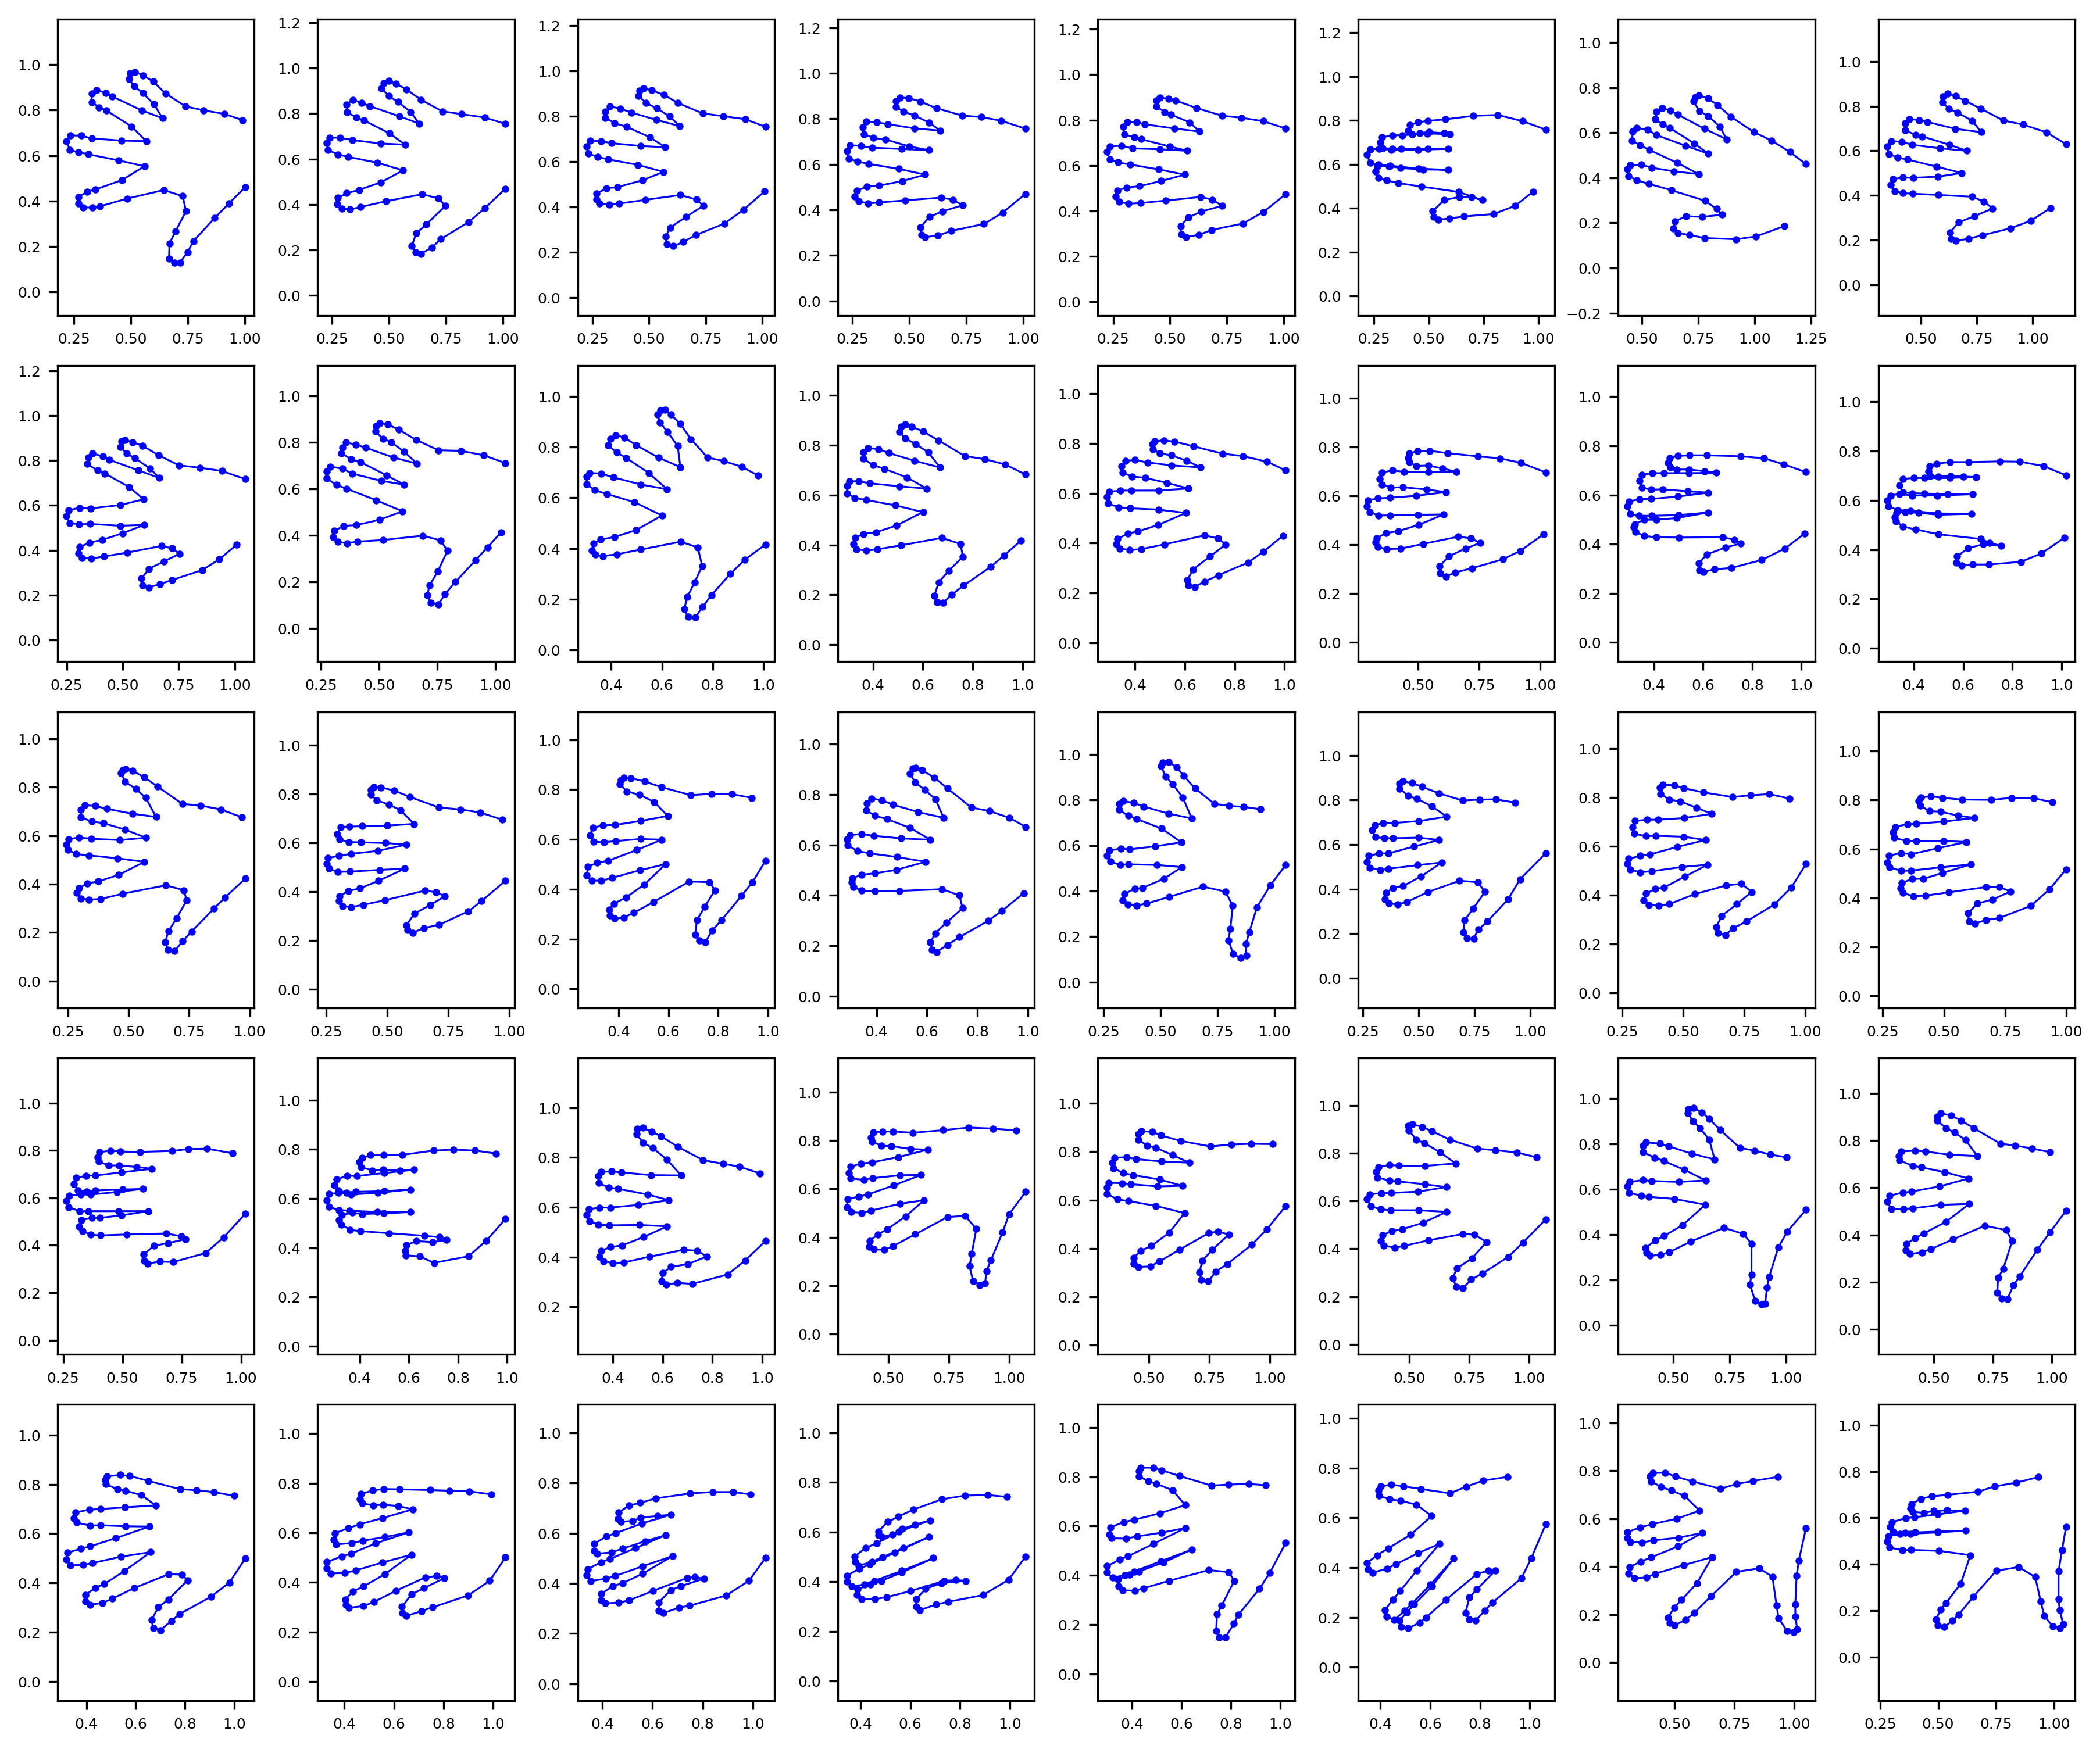

In [2]:
# Load the dataset
with h5FileReader('data/hands2D.mat') as file_hand:
    hand_outlines = np.array(file_hand['shapes'])

# The dataset contains 40 hand shapes, each with 20 points (x, y) coordinates
_, hand_axes = plt.subplots(5, 8, figsize=(12, 10), dpi=300)

for i, pointset in enumerate(hand_outlines):
    ax = hand_axes[i // 8, i % 8]
    ax.plot(pointset[:, 0], pointset[:, 1], marker='o', markersize=2, color='blue', linewidth=0.75)
    ax.axis('equal')

plt.tight_layout()
plt.show()

In [3]:
def normalize(x):
    x = x - x.mean(axis=0)
    scale = np.linalg.norm(x)
    return x / scale


# Code 1
def align_rotation_only(x, y):
    u, _, vt = np.linalg.svd(y.T @ x)
    r = u @ vt
    return y @ r


# Code 2
def align_similarity(x, y):
    x_centered = x - x.mean(axis=0)
    y_centered = y - y.mean(axis=0)
    norm_x = np.linalg.norm(x_centered)
    norm_y = np.linalg.norm(y_centered)
    xn = x_centered / norm_x
    yn = y_centered / norm_y
    u, _, vt = np.linalg.svd(yn.T @ xn)
    r = u @ vt
    s = (norm_x / norm_y)
    t = x.mean(axis=0) - s * y.mean(axis=0) @ r
    return s * y @ r + t


def code11(shapes, max_iter=10):
    aligned = np.array([normalize(s) for s in shapes])
    mean = aligned[0]
    for _ in range(max_iter):
        aligned = np.array([align_rotation_only(mean, s) for s in aligned])
        mean = np.mean(aligned, axis=0)
        mean = normalize(mean)
    return aligned, mean


def code22(shapes, max_iter=10):
    aligned = np.copy(shapes)
    mean = aligned[0]
    for _ in range(max_iter):
        aligned = np.array([align_similarity(mean, s) for s in aligned])
        mean = np.mean(aligned, axis=0)
    return aligned, mean

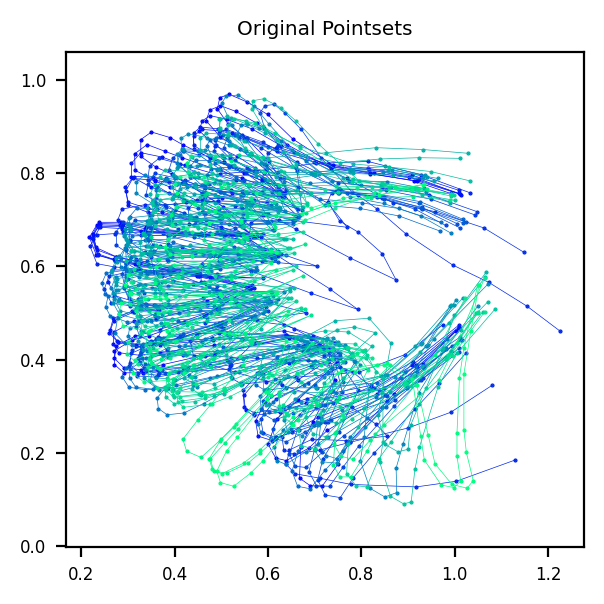

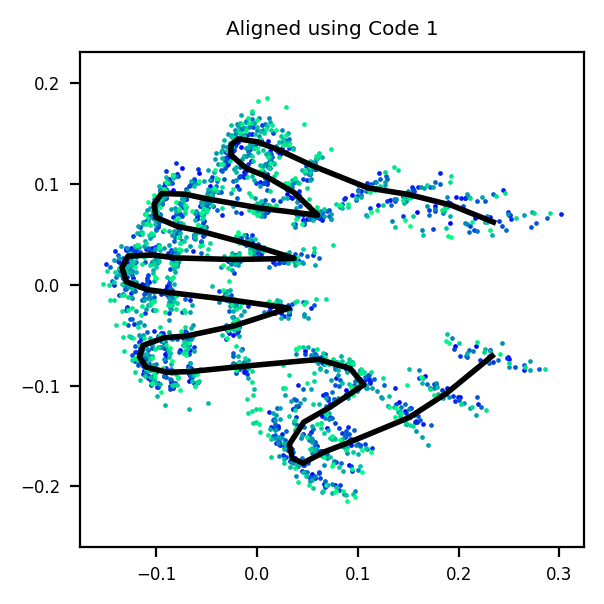

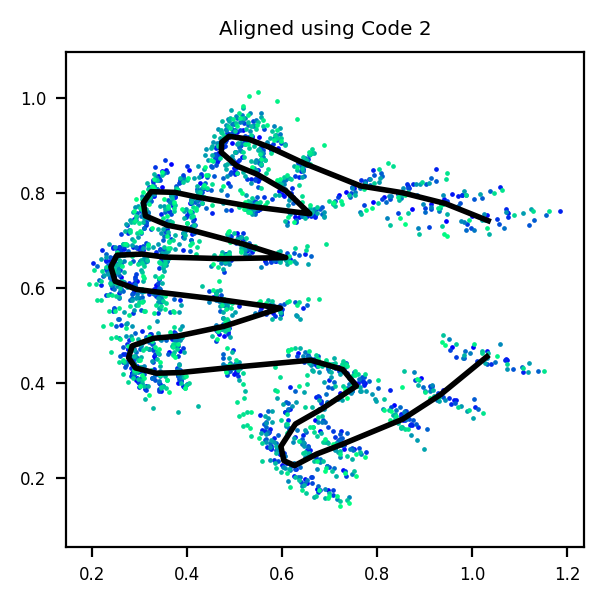

In [4]:
raw_colors = plt.get_cmap('winter')(np.linspace(0, 1, len(hand_outlines)))
plt.figure(figsize=(3, 3), dpi=200)
for i, shape in enumerate(hand_outlines):
    plt.plot(shape[:, 0], shape[:, 1], color=raw_colors[i], marker='o', markersize=0.5, linewidth=0.25)
plt.title("Original Pointsets")
plt.axis('equal')
plt.tight_layout()
plt.show()

aligned1, mean1 = code11(hand_outlines)
aligned2, mean2 = code22(hand_outlines)


def plot_shapes(aligned, mean, title):
    colors = plt.get_cmap('winter')(np.linspace(0, 1, len(aligned)))
    plt.figure(figsize=(3, 3), dpi=200)
    for idx, hand_shape in enumerate(aligned):
        plt.scatter(hand_shape[:, 0], hand_shape[:, 1], color=colors[idx], s=0.5)
    plt.plot(mean[:, 0], mean[:, 1], 'k-', linewidth=2, label='Mean')
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


plot_shapes(aligned1, mean1, "Aligned using Code 1")
plot_shapes(aligned2, mean2, "Aligned using Code 2")

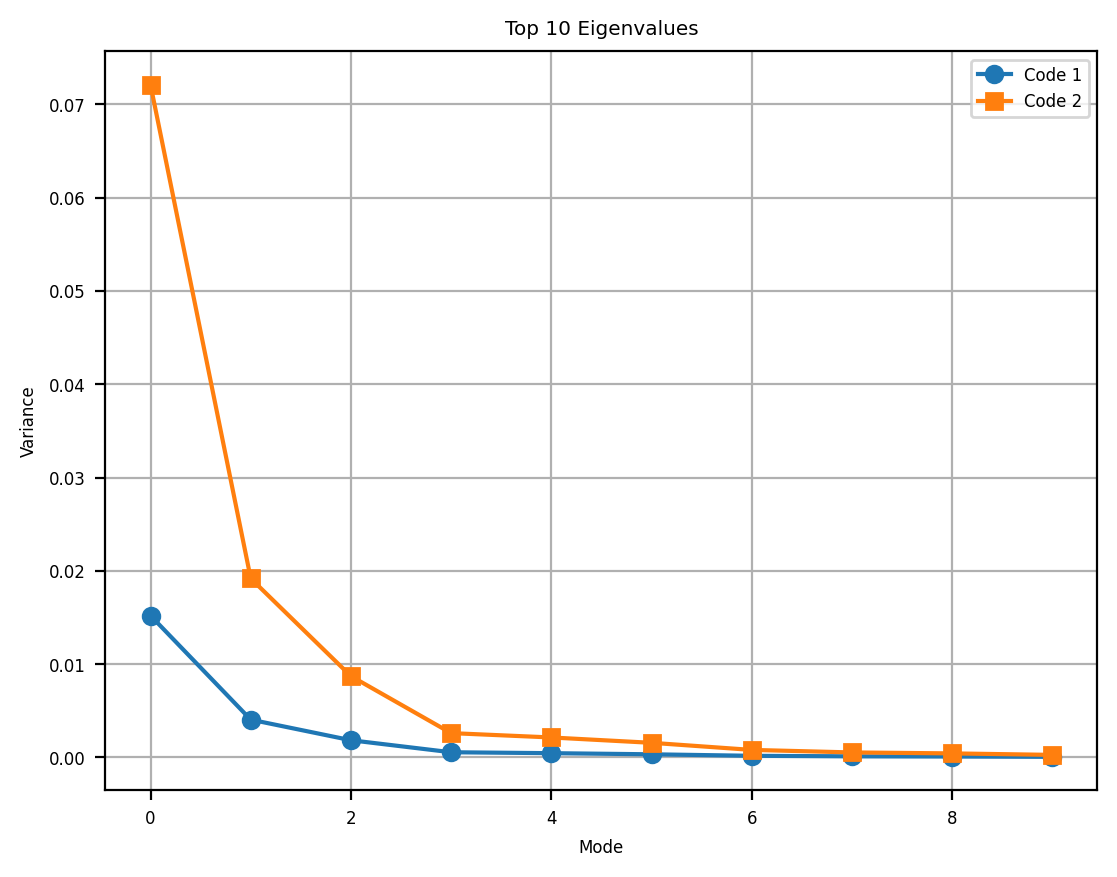

In [5]:
def compute_pca(aligned):
    n, p, d = aligned.shape
    flat = aligned.reshape(n, p * d)
    mean_flat = np.mean(flat, axis=0)
    centered = flat - mean_flat
    u, s, vt = np.linalg.svd(centered, full_matrices=False)
    eigenvalues = (s ** 2) / (n - 1)
    eigenvectors = vt.T
    return eigenvalues, eigenvectors, mean_flat.reshape(p, d)


eigenvalues1, eigenvectors1, _ = compute_pca(np.array(aligned1))
eigenvalues2, eigenvectors2, _ = compute_pca(np.array(aligned2))

plt.figure(dpi=200)
plt.plot(eigenvalues1[:10], 'o-', label='Code 1')
plt.plot(eigenvalues2[:10], 's-', label='Code 2')
plt.title("Top 10 Eigenvalues")
plt.xlabel("Mode")
plt.ylabel("Variance")
plt.legend()
plt.grid()
plt.show()

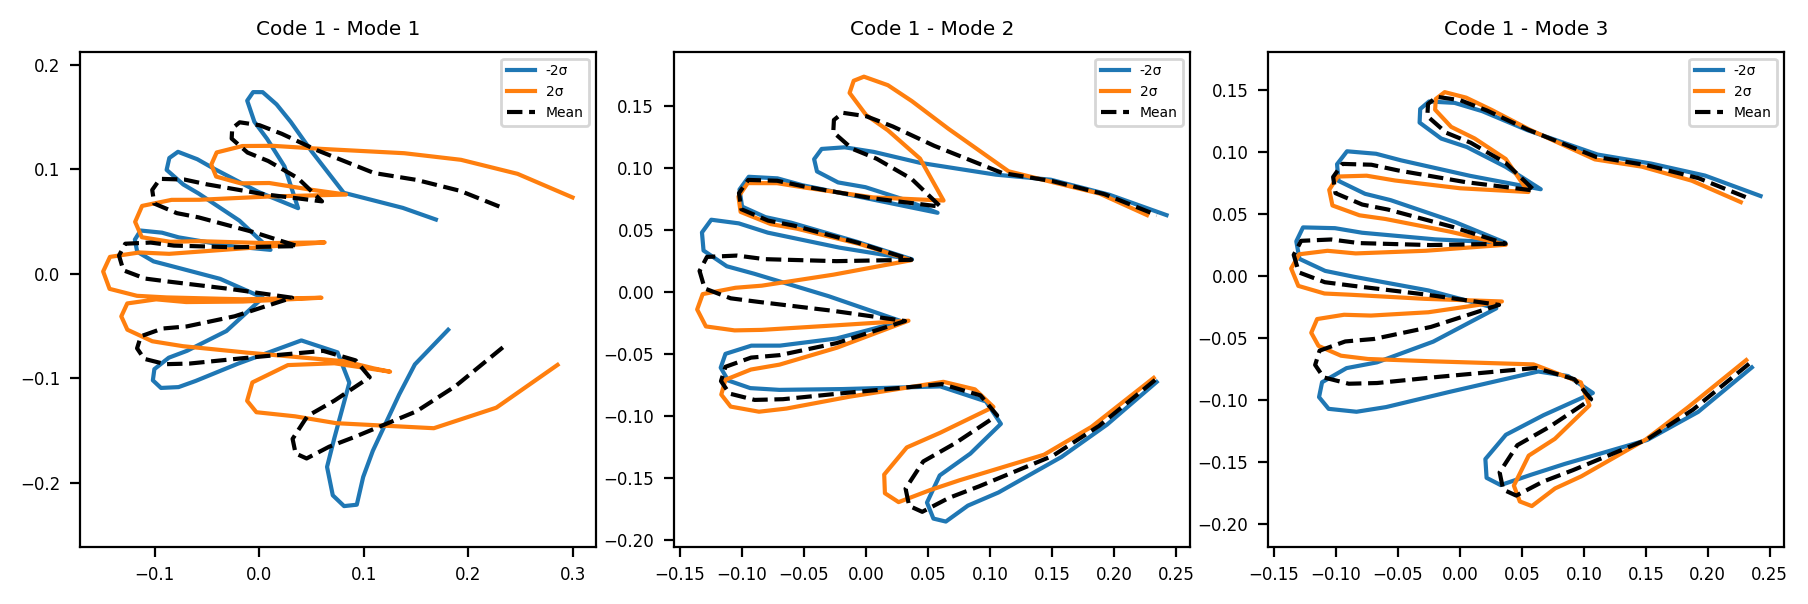

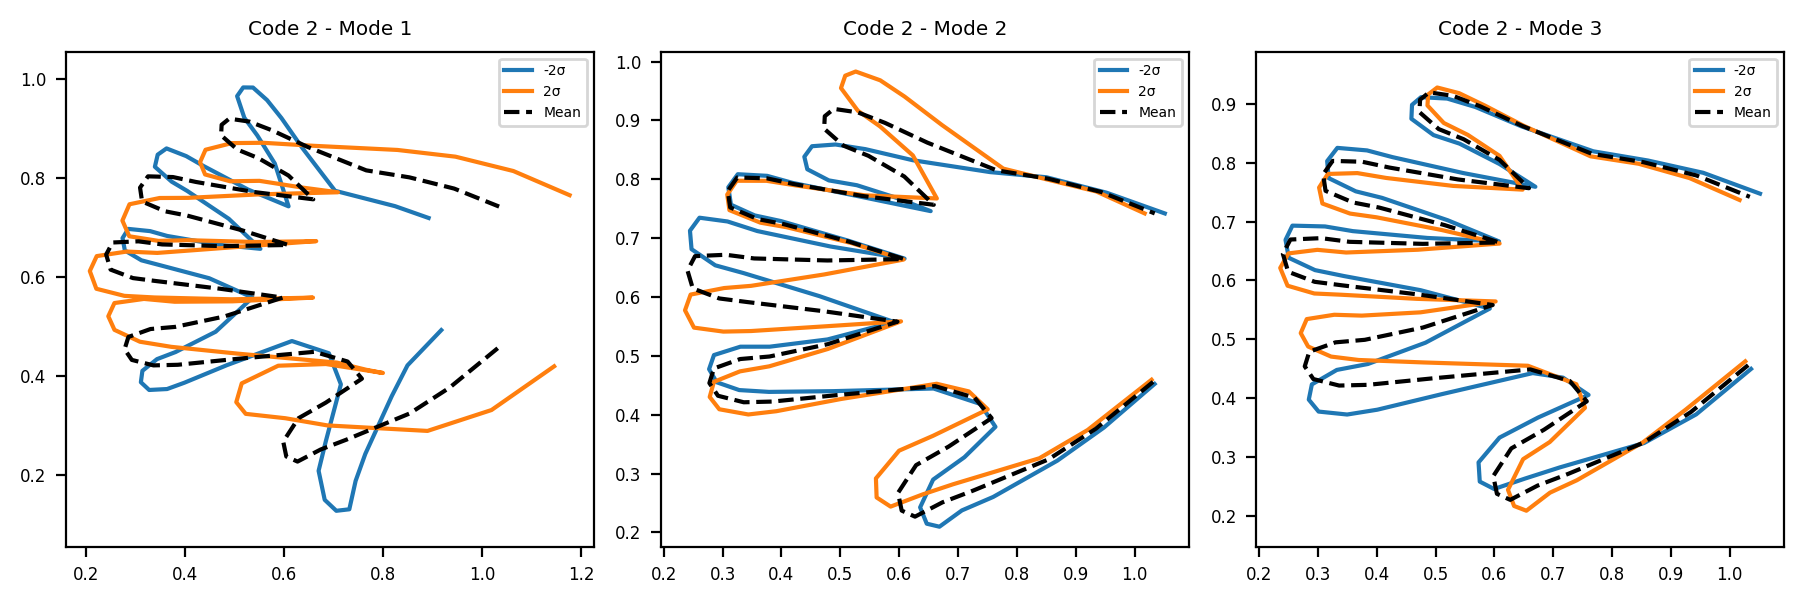

In [6]:
def show_modes(mean_shape, eigenvalues, eigenvectors, title_prefix):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=200)
    for idx in range(3):
        vec = eigenvectors[:, idx].reshape(mean_shape.shape)
        sigma = np.sqrt(eigenvalues[idx])
        idx_ax = axes[idx]
        for k in [-2, 2]:
            handle_shape = mean_shape + k * sigma * vec
            idx_ax.plot(handle_shape[:, 0], handle_shape[:, 1], label=f'{k}σ')
        idx_ax.plot(mean_shape[:, 0], mean_shape[:, 1], 'k--', label='Mean')
        idx_ax.set_title(f'{title_prefix} - Mode {idx + 1}')
        idx_ax.axis('equal')
        idx_ax.legend(fontsize=5)
    plt.tight_layout()
    plt.show()


show_modes(mean1, eigenvalues1, eigenvectors1, "Code 1")
show_modes(mean2, eigenvalues2, eigenvectors2, "Code 2")